In [34]:
import os
import haiku as hk
import jax
import mediapy as media
import numpy as np
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils

import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.color

In [36]:
notebooks_path = os.getcwd()
TAPIR_path = os.path.dirname(notebooks_path)
tapnet_path = os.path.join(TAPIR_path, 'tapnet')
tapnet_path

'g:\\My Drive\\01_Postdoc_HMGU\\Python_MyScripts\\MIA\\Git\\TAPIR\\tapnet'

In [37]:
checkpoint_path = os.path.join(tapnet_path, 'checkpoints', 'tapir_checkpoint.npy')
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']
checkpoint_path

'g:\\My Drive\\01_Postdoc_HMGU\\Python_MyScripts\\MIA\\Git\\TAPIR\\tapnet\\checkpoints\\tapir_checkpoint.npy'

In [38]:
def build_model(frames, query_points):
  """Compute point tracks and occlusions given frames and query points."""
  model = tapir_model.TAPIR()
  outputs = model(
      video=frames,
      is_training=False,
      query_points=query_points,
      query_chunk_size=64,
  )
  return outputs

model = hk.transform_with_state(build_model)
model_apply = jax.jit(model.apply)

In [39]:
def preprocess_frames(frames):
  """Preprocess frames to model inputs.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], float

  Returns:
    frames: [num_frames, height, width, 3], [-1, 1], np.float32
  """
  frames = frames.astype(np.float32)
  frames = frames * 2 - 1
  return frames


def postprocess_occlusions(occlusions, expected_dist):
  """Postprocess occlusions to boolean visible flag.

  Args:
    occlusions: [num_points, num_frames], [-inf, inf], np.float32
    expected_dist: [num_points, num_frames], [-inf, inf], np.float32

  Returns:
    visibles: [num_points, num_frames], bool
  """
  # visibles = occlusions < 0
  visibles = (1 - jax.nn.sigmoid(occlusions)) * (1 - jax.nn.sigmoid(expected_dist)) > 0.5
  return visibles

def inference(frames, query_points):
  """Inference on one video.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8
    query_points: [num_points, 3], [0, num_frames/height/width], [t, y, x]

  Returns:
    tracks: [num_points, 3], [-1, 1], [t, y, x]
    visibles: [num_points, num_frames], bool
  """
  # Preprocess video to match model inputs format
  frames = preprocess_frames(frames)
  num_frames, height, width = frames.shape[0:3]
  query_points = query_points.astype(np.float32)
  frames, query_points = frames[None], query_points[None]  # Add batch dimension

  # Model inference
  rng = jax.random.PRNGKey(42)
  outputs, _ = model_apply(params, state, rng, frames, query_points)
  outputs = tree.map_structure(lambda x: np.array(x[0]), outputs)
  tracks, occlusions, expected_dist = outputs['tracks'], outputs['occlusion'], outputs['expected_dist']

  # Binarize occlusions
  visibles = postprocess_occlusions(occlusions, expected_dist)
  return tracks, visibles

In [40]:
test_data_path = os.path.join(TAPIR_path, 'data', 'test_data')
images_path = os.path.join(
    test_data_path, 'Yagya_Kurt_Presentation', 'Position_6', 'Images'
)
video_tif_path = os.path.join(images_path, 'SCGE_5strains_23092021_Dia_Ph3.tif')
video_tif_path

'g:\\My Drive\\01_Postdoc_HMGU\\Python_MyScripts\\MIA\\Git\\TAPIR\\data\\test_data\\Yagya_Kurt_Presentation\\Position_6\\Images\\SCGE_5strains_23092021_Dia_Ph3.tif'

In [71]:
segm_data_path = os.path.join(images_path, 'SCGE_5strains_23092021_segm.npz')
segm_data = np.load(segm_data_path)['arr_0']
segm_data.shape

(321, 559, 666)

In [72]:
frames = skimage.io.imread(video_tif_path) # segm_data.copy() # skimage.io.imread(video_tif_path)
frames = frames/frames.max()
frames = skimage.color.gray2rgb(frames)
frames = (frames*255).astype(np.uint8)

In [73]:
# Start from last frame
stop_frame_i = 50
segm_data = segm_data[:stop_frame_i][::-1]
frames = frames[:stop_frame_i][::-1]

In [74]:
crop_half_height = 128  # @param {type: "integer"}
crop_half_width = 128  # @param {type: "integer"}

Y, X = segm_data.shape[-2:]
center_y = int(Y/2)
center_x = int(X/2)
slice_y = slice(center_y-crop_half_height, center_y+crop_half_height)
slice_x = slice(center_x-crop_half_width, center_x+crop_half_width)

segm_data = segm_data[..., slice_y, slice_x].copy()

num_frames = len(frames)
frames = frames[..., slice_y, slice_x, :] # skimage.transform.resize(frames, (num_frames, crop_height, crop_width))
max_ID = segm_data.max()
max_ID, frames.shape


(3, (50, 256, 256, 3))

In [69]:
frames.shape

(50, 256, 256, 3)

In [49]:
cmap = plt.get_cmap('gist_rainbow')

frames_rgb = np.zeros((*frames.shape, 3), dtype=np.uint8)
for frame_i, lab in enumerate(segm_data):
    rp = skimage.measure.regionprops(lab)
    for obj in rp:
        rgb = [int(val*255) for val in cmap(obj.label/max_ID)][:3]
        frames_rgb[frame_i][obj.slice][obj.image] = rgb

frames = frames_rgb
    
media.show_video(frames, fps=10)

In [75]:
media.show_video(frames, fps=10)

In [77]:
frames.max(), frames.shape, segm_data.shape

(124, (50, 256, 256, 3), (50, 256, 256))

In [78]:
media.show_video(frames, fps=10)

In [79]:
lab = segm_data[0]
rp = skimage.measure.regionprops(lab)
query_points = []
for obj in rp:
    yc, xc = obj.centroid
    query_points.append((0, int(yc), int(xc)))
query_points = np.array(query_points)
query_points

array([[  0, 105,  72],
       [  0, 153,  95],
       [  0, 141, 129]])

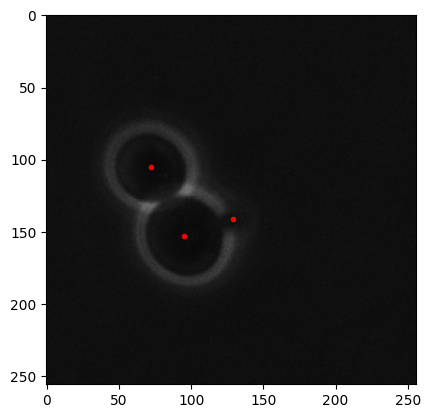

In [90]:
plt.imshow(frames[0])
plt.plot(query_points[:,2], query_points[:,1], 'r.')

In [91]:
tracks, visibles = inference(frames, query_points)

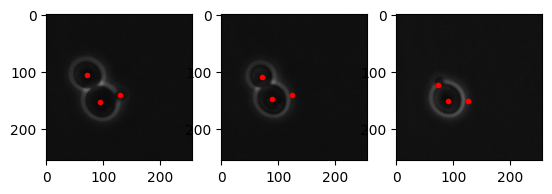

In [99]:
tracks.shape, frames.shape, tracks[1][-1]
first_track = tracks[0]
second_track = tracks[1]
third_track = tracks[2]

# tracks is (track, frames, x, y)

fig, ax = plt.subplots(1, 3)
frame_i = 0
ax[0].imshow(frames[frame_i])
ax[0].plot(first_track[frame_i][0], first_track[frame_i][1], 'r.')
ax[0].plot(second_track[frame_i][0], second_track[frame_i][1], 'g.')
ax[0].plot(third_track[frame_i][0], third_track[frame_i][1], 'b.')

frame_i = 25
ax[1].imshow(frames[frame_i])
ax[1].plot(first_track[frame_i][0], first_track[frame_i][1], 'r.')
ax[1].plot(second_track[frame_i][0], second_track[frame_i][1], 'g.')
ax[1].plot(third_track[frame_i][0], third_track[frame_i][1], 'b.')

frame_i = -1
ax[2].imshow(frames[frame_i])
ax[2].plot(first_track[frame_i][0], first_track[frame_i][1], 'r.')
ax[2].plot(second_track[frame_i][0], second_track[frame_i][1], 'g.')
ax[2].plot(third_track[frame_i][0], third_track[frame_i][1], 'b.')

In [83]:
# Visualize sparse point tracks
video = frames
height, width = video.shape[1:3]
tracks = transforms.convert_grid_coordinates(
    tracks, (1, 1), (width, height)
)
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)